In [1]:
import os
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
from matplotlib import cm
from matplotlib import colors
!pip install plydata
from plydata.cat_tools import *

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Load the CSV files
dir_base = '/content/gdrive/My Drive/Personal/Podcast/ep8_eric'
os.chdir(dir_base)
df_cancer = pd.read_csv('1310039401.csv',usecols=['year','number'])
df_cancer.rename(columns={'year':'years','number':'cancer'}, inplace=True)
df_pop = pd.read_csv('1710000501.csv')
df_pop = df_pop.melt('years',None,'grp','population')
# Raw rate per 100K
df_pop_total = df_pop.query('grp=="All ages"').drop(columns='grp').rename(columns={'population':'total'})
df_rate = df_pop_total.merge(df_cancer,how='right',on='years').assign(rate=lambda x: x.cancer/(x.total/100000))
# We are about 4% higher on a population level

### Aggregate population statistics

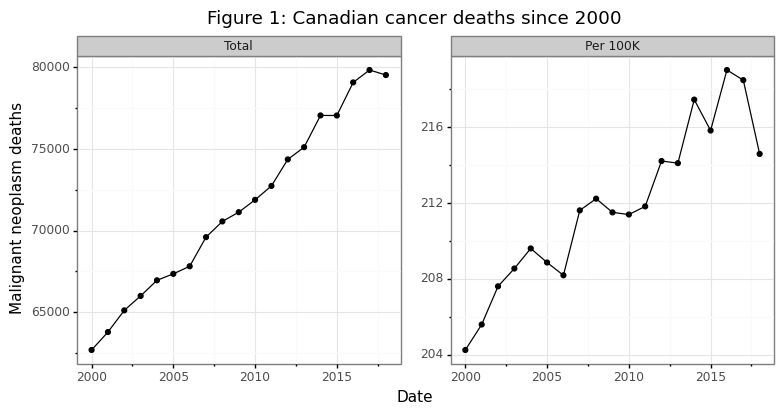

<ggplot: (-9223363263279091154)>

In [3]:
tmp = df_rate.melt('years',['cancer','rate'],'tt')
tmp.head()
plotnine.options.figure_size = (9, 4)
gg_agg = (ggplot(tmp,aes(x='years',y='value')) + theme_bw() + 
          geom_point() + geom_line() + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'cancer':'Total','rate':'Per 100K'})) + 
          labs(y='Malignant neoplasm deaths', x='Date') + 
          ggtitle('Figure 1: Canadian cancer deaths since 2000') + 
          theme(panel_spacing_x=0.5))
gg_agg

### Age-specific mortality rates

In [4]:
# Age-specific cancer
df_age = pd.read_csv('1310039401_by_age.csv')
df_age.age = df_age.age.str.split('\\,\\s',expand=True).iloc[:,1]
df_age.age = df_age.age.fillna(method='ffill')
df_age.age = df_age.age.str.replace('\\syears','')
# Age-specific population
di_age = {'0 to 4':'1 to 14', '5 to 9':'1 to 14', '10 to 14':'1 to 14',
          '15 to 19':'15 to 24', '20 to 24':'15 to 24',
          '25 to 29':'25 to 34', '30 to 34':'25 to 34',
          '35 to 39':'35 to 44', '40 to 44':'35 to 44',
          '45 to 49':'45 to 54', '50 to 54':'45 to 54',
          '55 to 59':'55 to 64', '60 to 64':'55 to 64',
          '65 to 69':'65 to 74', '70 to 74':'65 to 74',
          '75 to 79':'75 to 84', '80 to 84':'75 to 84',
          '85 to 89':'85 and over','90 to 94':'85 and over',
          '95 to 99':'85 and over', '100 and over':'85 and over',
          'Under 1 year':'1 to 14', '1 to 4':'1 to 14', '90 and over':'85 and over'}
df_pop_sub = df_pop.query('grp!="All ages"').assign(grp=lambda x: x.grp.str.replace('\\syears',''))
df_pop_sub = df_pop_sub.assign(age=lambda x: x.grp.map(di_age)).groupby(['years','age']).population.sum().reset_index()
# Merge
df_age = df_pop_sub.merge(df_age,how='right',on=['years','age'])
df_age = df_age.assign(rate=lambda x: x.number/(x.population/1e5))

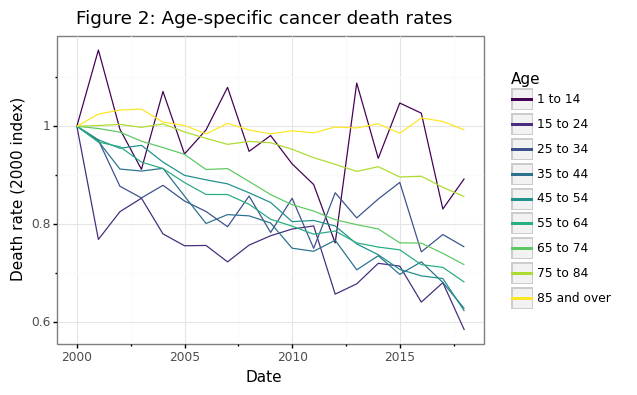

<ggplot: (8773572640611)>

In [5]:
# Get the population-age bracket weights
# Get the aggregate population growth
cn = ['years','age','rate']
tmp2 = df_age[cn].merge(df_age[cn].groupby('age').head(1).drop(columns='years').rename(columns={'rate':'idx'}),'left','age')
tmp2 = tmp2.assign(adj = lambda x: x.rate / x.idx)
tmp2 = tmp2.assign(age2=lambda x: pd.Categorical(x.age,x.age.unique()).codes)
# Get colors
lblz = list(tmp2.age.unique())
n_age = len(lblz)
mat = cm.get_cmap('viridis',n_age).colors
colz = []
for ii in range(n_age):
  colz.append(colors.to_hex(mat[ii]))
# Make plot
plotnine.options.figure_size = (5.5, 4)
gg_rate_age = (ggplot(tmp2,aes(x='years',y='adj',color='age')) + 
               theme_bw() + geom_path() + 
               labs(y='Death rate (2000 index)',x='Date') + 
               ggtitle('Figure 2: Age-specific cancer death rates') + 
               scale_color_manual(name='Age',values=colz,labels=lblz))
gg_rate_age

### Population indexed cancer death rates

Assume the population composition of Canada was fixed at the year 2000

In [6]:
df_pop_r = df_pop_total.assign(r=lambda x: x.total/x.total.head(1).values).drop(columns='total')
df_idx = df_age.assign(population=lambda x: np.where(x.years==x.years.head(1).values[0],x.population,np.NaN)).drop(columns='number')
df_idx.population = df_idx.groupby('age').population.fillna(method='ffill')
df_idx = df_idx.merge(df_pop_r,'left','years').assign(population=lambda x: x.population*x.r)
df_idx = df_idx.assign(cancer=lambda x: x.rate*(x.population/1e5))
df_idx = df_idx.groupby('years')['population','cancer'].sum().astype(int).reset_index()
df_idx = df_idx.assign(rate=lambda x: x.cancer/(x.population/1e5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


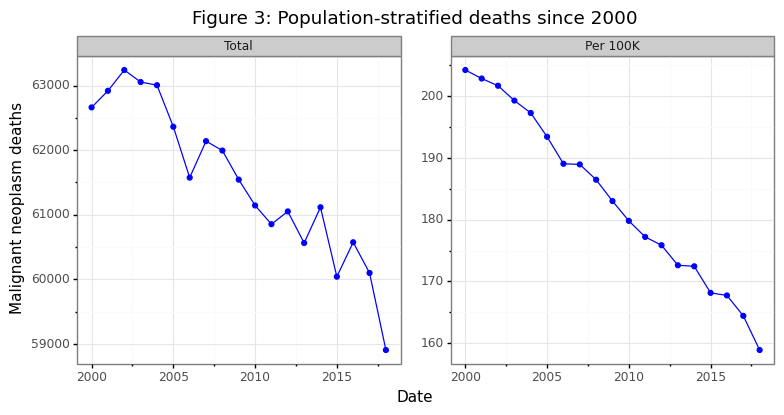

<ggplot: (8773572593584)>

In [7]:
tmp3 = df_idx.melt('years',['cancer','rate'],'tt')
plotnine.options.figure_size = (9, 4)
gg_theory = (ggplot(tmp3,aes(x='years',y='value')) + theme_bw() + 
          geom_point(color='blue') + geom_line(color='blue') + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'cancer':'Total','rate':'Per 100K'})) + 
          labs(y='Malignant neoplasm deaths', x='Date') + 
          ggtitle('Figure 3: Population-stratified deaths since 2000') + 
          theme(panel_spacing_x=0.5))
gg_theory

### Age-specific mortality factors


In [17]:
df_type = pd.read_csv('1310014201_type_age.csv')
df_type.rename(columns={'Age group':'age','Cause of death (ICD-10)':'cod','VALUE':'number'},inplace=True)
drop_age = ['Total, all ages','Age, not stated']
drop_cod = ['Total, all causes of death [A00-Y89]','Chapter II: Neoplasms [C00-D48]','Malignant neoplasms [C00-C97]']
df_type = df_type[~(df_type.age.isin(drop_age) | df_type.cod.isin(drop_cod))].reset_index(None,True)
df_type.age = df_type.age.str.replace('\\syears','').map(di_age)
df_type.cod = df_type.cod.str.replace('Malignant neoplasms{0,1} of ','').str.split('\\s\\[',expand=True).iloc[:,0]
di_cod = {'Melanoma and other malignant neoplasms of skin':'melanoma',
       'bone and articular cartilage':'bone',
       'breast':'breast', 'digestive organs':'digestive',
       'eye, brain and other parts of central nervous system':'brain/eye/CNS',
       'female genital organs':'female sex organ',
       'ill-defined, secondary and unspecified sites':'ill-defined',
       'lip, oral cavity and pharynx':'mouth',
       'lymphoid, haematopoietic and related tissue':'lymphoid',
       'male genital organs':'male sex organ',
       'mesothelial and soft tissue':'mesothelial',
       'respiratory and intrathoracic organs':'respitory',
       'thyroid and other endocrine glands':'thryoid',
       'urinary tract':'urinary'}
df_type = df_type.assign(cod=lambda x: x.cod.map(di_cod))
df_type = df_type.merge(df_age[['years','age','population']],'left',['years','age'])
df_type = df_type.assign(rate=lambda x: x.number/(x.population/1e5))
# Calculation population-consistent population
df_alt_type = df_type.drop(columns='number').assign(population=lambda x: np.where(x.years==x.years.head(1).values[0],x.population,np.NaN))
df_alt_type.population = df_alt_type.groupby(['age','age']).population.fillna(method='ffill')
df_alt_type = df_alt_type.merge(df_pop_r,'left','years').assign(population=lambda x: (x.population*x.r).astype(int))
df_alt_type = df_alt_type.assign(number=lambda x: x.rate*x.population/1e5)
n_fac = 6
df_alt_type = df_alt_type.assign(cod2=lambda x: cat_lump(c=x.cod,w=x.number,n=n_fac))
tmp1 = df_alt_type.groupby(['years','age','cod2']).number.sum().reset_index()
tmp1 = tmp1.groupby(['years','cod2']).number.sum().reset_index()
df_cod2 = tmp1.merge(df_pop_total,'left','years').assign(rate=lambda x: x.number/(x.total/1e5))
df_cod2 = df_cod2.sort_values(['cod2','years']).reset_index(None,True)
df_cod2 = df_cod2.assign(tmp=lambda x: pd.Series(np.where(x.years==x.years.head(1).values[0],x.rate,np.NaN)).fillna(method='ffill'))
df_cod2 = df_cod2.assign(idx=lambda x: x.rate/x.tmp, rate_diff=lambda x: x.rate-x.tmp)
df_cod2_long = df_cod2.melt(['years','cod2'],['rate','idx'],'tt')

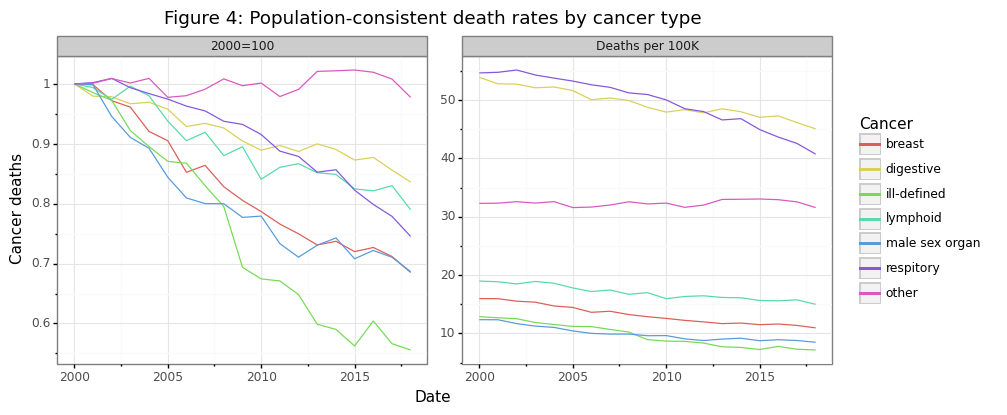

<ggplot: (8773570917836)>

In [12]:
plotnine.options.figure_size = (10, 4)
gg_cod = (ggplot(df_cod2_long, aes(x='years',y='value',color='cod2')) + 
          theme_bw() + geom_path() + 
          labs(x='Date',y='Cancer deaths') + 
          facet_wrap('~tt',scales='free_y',labeller=labeller(tt={'idx':'2000=100','rate':'Deaths per 100K'})) + 
          ggtitle('Figure 4: Population-consistent death rates by cancer type') + 
          theme(panel_spacing_x=0.35) + 
          scale_color_discrete(name='Cancer'))
gg_cod

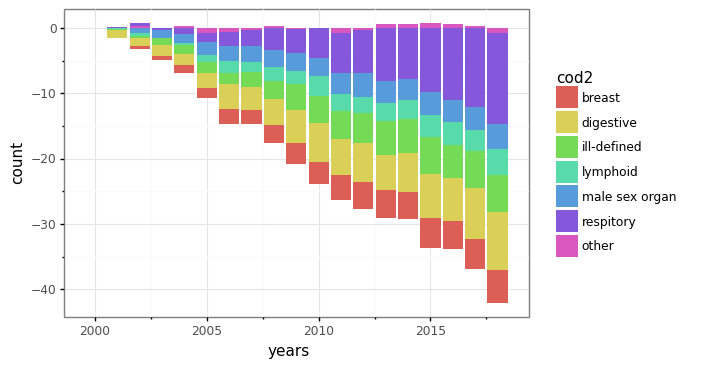

<ggplot: (8773570312396)>

In [26]:
plotnine.options.figure_size = (6, 4)
gg_diff = (ggplot(df_cod2,aes(x='years',weight='rate_diff',fill='cod2')) + 
           theme_bw() + geom_bar())
gg_diff

### Who is being "saved"?

In [10]:
# tmp1 = df_cod2[['years','cod2','number']].rename(columns={'number':'counter'})
# tmp2 = df_type.assign(cod2=lambda x: cat_lump(c=x.cod,w=x.number,n=n_fac)).groupby(['years','cod2']).number.sum().reset_index()
# df_saved = tmp2.merge(tmp1,'left',['years','cod2']).assign(saved=lambda x: x.number - x.counter)
# plotnine.options.figure_size = (6, 4)
# gg_saved = (ggplot(df_saved,aes(x='years',weight='saved',fill='cod2')) + 
#             theme_bw() + geom_bar())
# gg_saved